In [1]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
import shap
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.factory import get_performance_indicator
from optuna.exceptions import TrialPruned
from autocluster.autohypothesis import autohypothesis_utils

In [2]:
sk_iris = datasets.load_iris()
iris = pd.DataFrame(sk_iris['data'], columns=sk_iris['feature_names'])
iris['target'] = sk_iris['target']
sk_cancer = datasets.load_breast_cancer()
cancer = pd.DataFrame(sk_cancer['data'], columns=sk_cancer['feature_names'])
cancer['target'] = sk_cancer['target']
sk_wine = datasets.load_wine()
wine = pd.DataFrame(sk_wine['data'], columns=sk_wine['feature_names'])
wine['target'] = sk_wine['target']
star_df = pd.read_csv('star_classification.csv')
star_df.rename(columns={"class": "target"}, inplace=True)
star_df.drop(columns=['obj_ID',"fiber_ID","run_ID","rerun_ID","field_ID","spec_obj_ID","fiber_ID"], inplace=True)#,"redshift"
_, star_df = train_test_split(star_df, test_size=0.05, stratify=star_df['target'], random_state=42)

In [3]:
import pandas as pd
import numpy as np

# Initialisation de la liste pour stocker les résultats
results = []

# Nombre de runs
n_runs = 1  # Définissez n selon votre besoin

for run in range(n_runs):
    # Exécutez le code original
    #exp, X_train, X_dev, y_train, y_dev = opti_loop(iris, 200, norm="minmax", optimize_obj="solo")
    exp, X_train, X_dev, y_train, y_dev = autohypothesis_utils.opti_loop(iris, 500,  optimize_obj="solo")
    all_objectives = np.array([trial.values for trial in exp.best_trials])
    sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
    params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=exp.best_trials[0].number)
    pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_dev, pipeline.predict(X_dev))
    entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
    
    # Stockage des résultats pour cette itération
    results.append({
        "run_number": run + 1,
        "accuracy": acc,
        "entropy": 1 - entropy,
        "params": exp.best_trials[0].params
    })

# Création du DataFrame pour toutes les runs
df_runs = pd.DataFrame(results)

# Calcul de la moyenne des accuracies et entropies
avg_accuracy = np.mean(df_runs["accuracy"])
avg_entropy = np.mean(df_runs["entropy"])

# Création du DataFrame pour les moyennes
df_avg = pd.DataFrame([{
    "avg_accuracy": avg_accuracy,
    "avg_entropy": avg_entropy
}])

print(df_runs)
print(df_avg)


[I 2024-04-25 13:54:51,160] A new study created in memory with name: no-name-bd244c40-a894-4bec-b9d4-0770905441fa
[I 2024-04-25 13:54:51,665] Trial 0 finished with value: 0.9333333333333333 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 370, 'rf_max_depth': 12, 'rf_min_samples_split': 0.3969502825841637, 'rf_min_samples_leaf': 0.19144030197386816, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 0 with value: 0.9333333333333333.
[I 2024-04-25 13:54:52,203] Trial 1 finished with value: 0.3333333333333333 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 410, 'rf_max_depth': 7, 'rf_min_samples_split': 0.9109013461208079, 'rf_min_samples_leaf': 0.26508879124609197, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 0 with value: 0.9333333333333333.
[I 2024-04-25 13:54:52,610] Trial 2 finished with value: 0.9333333333333333 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 300, 'rf_max_depth': 25, 'rf_min_samp

   run_number  accuracy   entropy  \
0           1  0.977778  0.743294   

                                              params  
0  {'classifier': 'RandomForest', 'rf_n_estimator...  
   avg_accuracy  avg_entropy
0      0.977778     0.743294


In [4]:
df_runs.to_csv("runs_solo_iris_500.csv")
df_avg.to_csv("avg_solo_iris_500.csv")

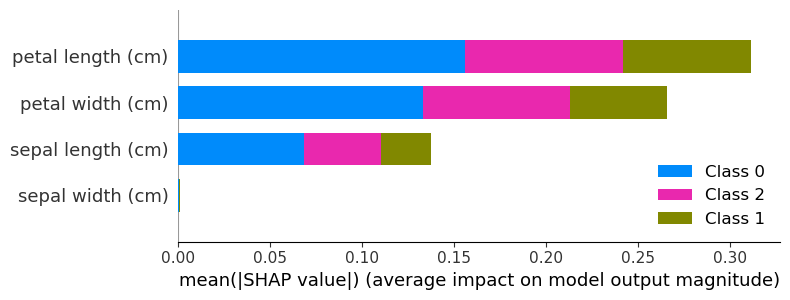

In [5]:
import shap

# Initialize your explainer
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
explain_shap = explainer(X_dev)
# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [6]:
vect = np.mean(np.abs(shap_values[1]), axis=0) 
I_c_minmax = (vect - np.min(vect)) / (np.max(vect) - np.min(vect))
sum_I_c_minmax = np.sum(I_c_minmax)
I_c_normalized = I_c_minmax / sum_I_c_minmax

In [7]:
vect

array([0.02687978, 0.00038373, 0.06966846, 0.05264583])

In [8]:
I_c_normalized

array([0.1789755, 0.       , 0.4680045, 0.35302  ])

In [9]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 19, 1: 3, 2: 9}


In [10]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


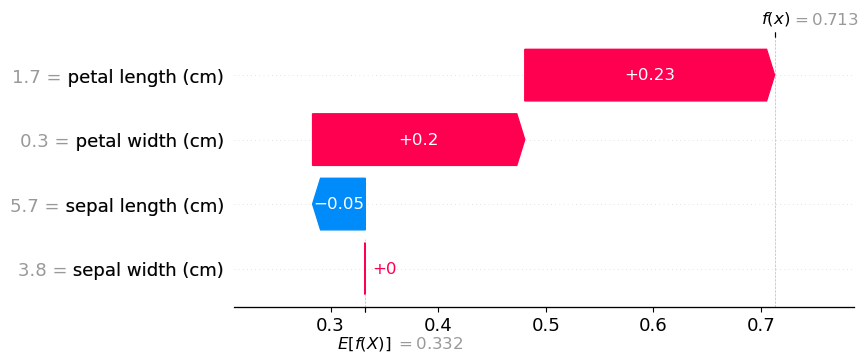

In [11]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

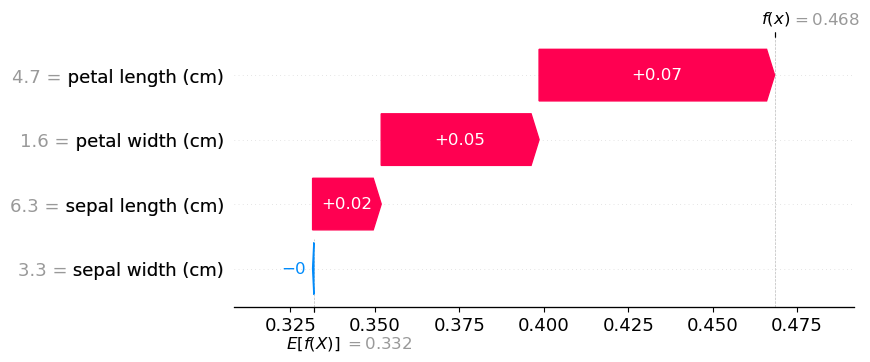

In [13]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [14]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

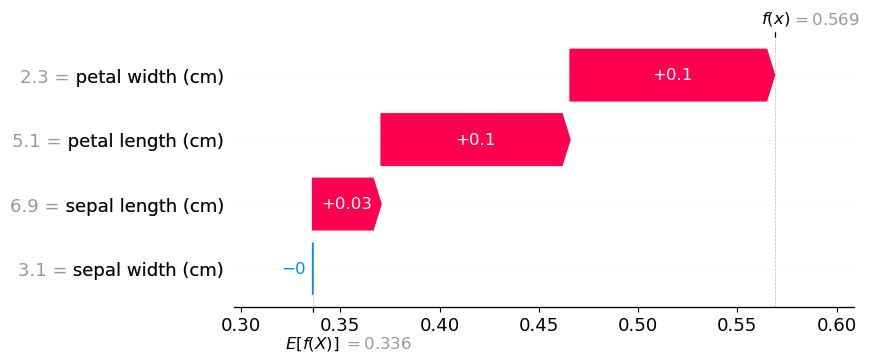

In [15]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))